# Modeling and Simulation in Python

Chapter 8

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html

### Functions from the previous chapter

In [2]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

In [3]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

### Reading the data

In [4]:
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

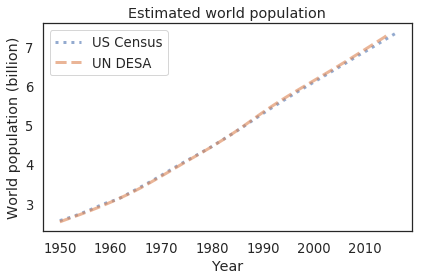

In [5]:
un = table2.un / 1e9
census = table2.census / 1e9
plot(census, ':', label='US Census')
plot(un, '--', label='UN DESA')
    
decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title='Estimated world population')

### Running the quadratic model

Here's the update function for the quadratic growth model with parameters `alpha` and `beta`.

In [6]:
def update_func_quad(pop, t, system):
    """Update population based on a quadratic model.
    
    pop: current population in billions
    t: what year it is
    system: system object with model parameters
    """
    return pop + system.alpha * pop + system.beta * pop**2

Extract the starting time and population.

In [7]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = get_first_value(census)

2.557628654

Initialize the system object.

In [8]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.025,
                beta=-0.0018)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
alpha,0.025000
beta,-0.001800


Run the model and plot results.

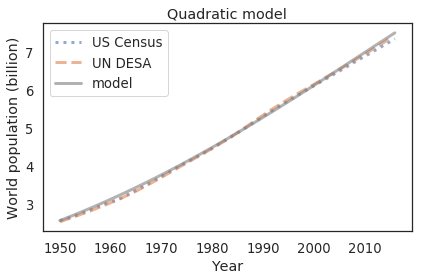

In [9]:
results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'Quadratic model')

### Generating projections

To generate projections, all we have to do is change `t_end`

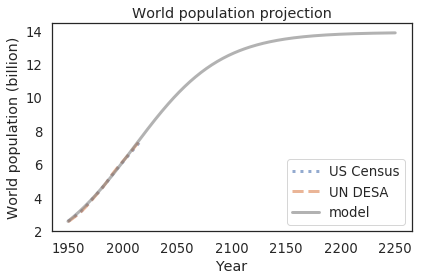

In [10]:
system.t_end = 2250
results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'World population projection')
# savefig('figs/chap04-fig01.pdf')

The population in the model converges on the equilibrium population, `-alpha/beta`

In [11]:
results[system.t_end]

13.856665141368701

In [12]:
-system.alpha / system.beta

13.88888888888889

**Exercise:**  What happens if we start with an initial population above the carrying capacity, like 20 billion?  Run the model with initial populations between 1 and 20 billion, and plot the results on the same axes.

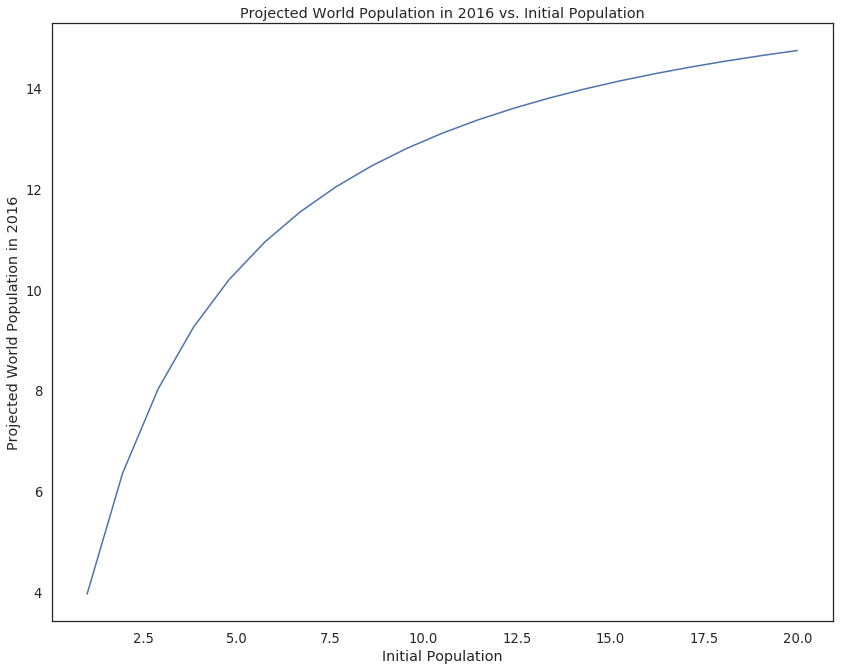

In [18]:
def init_p_sensitivity(p_array, t_0, t_end):
    p_results = pd.Series()
    for p in p_array:
        system = System(t_0=t_0, t_end=t_end, p_0=p, alpha=0.025, beta=-0.0018)
        p_results[p] = run_simulation(system, update_func_quad)[t_end]
    plt.figure(figsize=[14,11])
    p_results.plot()
    plt.title('Projected World Population in ' + str(t_end) + ' vs. Initial Population')
    plt.xlabel('Initial Population')
    plt.ylabel('Projected World Population in ' + str(t_end))
    
init_p_sensitivity(np.linspace(1, 20, 21), census.index[0], census.index[-1])

### Comparing projections

We can compare the projection from our model with projections produced by people who know what they are doing.

In [19]:
table3 = tables[3]
table3.head()

,United States Census Bureau (2015)[28],Population Reference Bureau (1973-2015)[15],United Nations Department of Economic and Social Affairs (2015)[16]
Year,,,
2016,7.334772e+09,NaN,7.432663e+09
2017,7.412779e+09,NaN,NaN
2018,7.490428e+09,NaN,NaN
2019,7.567403e+09,NaN,NaN
2020,7.643402e+09,NaN,7.758157e+09


`NaN` is a special value that represents missing data, in this case because some agencies did not publish projections for some years.

In [20]:
table3.columns = ['census', 'prb', 'un']

This function plots projections from the UN DESA and U.S. Census.  It uses `dropna` to remove the `NaN` values from each series before plotting it.

In [21]:
def plot_projections(table):
    """Plot world population projections.
    
    table: DataFrame with columns 'un' and 'census'
    """
    census_proj = table.census / 1e9
    un_proj = table.un / 1e9
    
    plot(census_proj.dropna(), 'b:', label='US Census')
    plot(un_proj.dropna(), 'g--', label='UN DESA')

Run the model until 2100, which is as far as the other projections go.

In [22]:
system = System(t_0=t_0, 
                t_end=2100,
                p_0=p_0,
                alpha=0.025,
                beta=-0.0018)

,values
t_0,1950.000000
t_end,2100.000000
p_0,2.557629
alpha,0.025000
beta,-0.001800


Saving figure to file figs/chap04-fig02.pdf


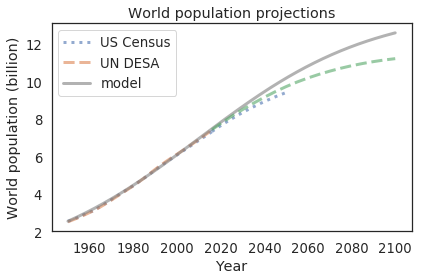

In [23]:
results = run_simulation(system, update_func_quad)

plot_results(census, un, results, 'World population projections')
plot_projections(table3)
savefig('figs/chap04-fig02.pdf')

People who know what they are doing expect the growth rate to decline more sharply than our model projects.

## Exercises

**Optional exercise:** The net growth rate of world population has been declining for several decades.  That observation suggests one more way to generate projections, by extrapolating observed changes in growth rate.

The `modsim` library provides a function, `compute_rel_diff`, that computes relative differences of the elements in a sequence.  It is a wrapper for the NumPy function `ediff1d`:

In [24]:
%psource compute_rel_diff

Here's how we can use it to compute the relative differences in the `census` and `un` estimates:

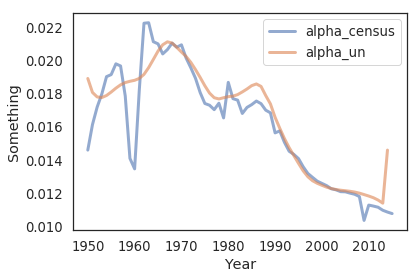

In [27]:
alpha_census = compute_rel_diff(census)
plot(alpha_census)

alpha_un = compute_rel_diff(un)
plot(alpha_un)

plt.xlabel('Year')
plt.ylabel('Something')
plt.legend(['alpha_census', 'alpha_un'])

Other than a bump around 1990, net growth rate has been declining roughly linearly since 1965.  As an exercise, you can use this data to make a projection of world population until 2100.

1. Define a function, `alpha_func`, that takes `t` as a parameter and returns an estimate of the net growth rate at time `t`, based on a linear function `alpha = intercept + slope * t`.  Choose values of `slope` and `intercept` to fit the observed net growth rates since 1965.

2. Call your function with a range of `ts` from 1960 to 2020 and plot the results.

3. Create a `System` object that includes `alpha_func` as a system variable.

4. Define an update function that uses `alpha_func` to compute the net growth rate at the given time `t`.

5. Test your update function with `t_0 = 1960` and `p_0 = census[t_0]`.

6. Run a simulation from 1960 to 2100 with your update function, and plot the results.

7. Compare your projections with those from the US Census and UN.

In [37]:
def alpha_func(t):
    return (census[1965] - census[census.index[-1]])/(census.index[-1] - 1965)*t + census[1965]

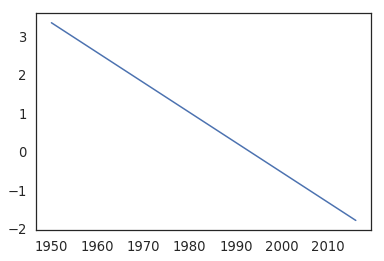

In [38]:
optional_results = TimeSeries()
for i in census.index:
    optional_results[i]=alpha_func(i-census.index[0])
optional_results.plot()

In [32]:
census.index

Int64Index([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
            1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
            1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
            1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
            1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
            2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
            2016],
           dtype='int64', name='Year')

In [39]:
sys_w_func = System(t_0=t_0, 
                t_end=2100,
                p_0=p_0,
                alpha = alpha_func)

,values
t_0,1950
t_end,2100
p_0,2.55763
alpha,<function alpha_func at 0x7f717d32de18>


In [50]:
def update_func_alpha(pop, t, system):
    return pop + pop*system.alpha(t-1965)

In [51]:
update_func_alpha(sys_w_func.p_0,sys_w_func.t_0, sys_w_func)

14.117371927268833

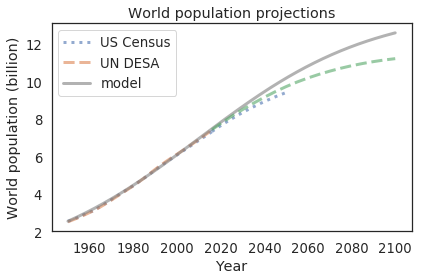

In [54]:
optional_results = run_simulation(sys_w_func, update_func_alpha)
plot_results(census, un, results, 'World population projections')
plot_projections(table3)

**Related viewing:** You might be interested in this [video by Hans Rosling about the demographic changes we expect in this century](https://www.youtube.com/watch?v=ezVk1ahRF78).

# Personal Work
The purpose of the following is to redo the models done above using purely base libraries (pandas and numpy, etc., as opposed to using modsim)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def data_parser(data_params):
    """
    Parses HTML table data of world population numbers
    
    Parameter:
        data_params:
            filename: path to the HTML file containing the table data
            table_choice_index: Select which table stored in the HTML file to use
            fit_data_index: Index of the data column within the table to fit the model to
            comp_data_index: Index of data column to be used to compare model results and original data to

    Returns:
        parsed_data: Series of two columns of data to be used in population growth models
            data_to_fit: Data to be fitted with population growth models
            data_to_compare: Additional data set to verify the model, and fitted data, against
    """
    
    # Load the tables
    tables = pd.read_html(data_params['filename'], header=0, index_col=0, decimal='M')
    
    # Parse tables to find desired data
    data_table = tables[data_params['table_choice_index']]
    data_column_to_fit = data_table.columns[data_params['fit_data_index']]
    data_column_to_compare = data_table.columns[data_params['comp_data_index']]
    data_to_fit = data_table[data_column_to_fit]
    data_to_compare = data_table[data_column_to_compare]
    
    # Store desired data columns in Series object
    parsed_data = pd.Series({"fit": data_to_fit, "comp": data_to_compare})
    return parsed_data

def lin_p_growth_update_constructor(data):
    """
    Takes data, and returns a function which iteratively updates population size by a proportional amount
    
    Parameter:
        data: values that the updater function is to be constructed using
    
    Returns:
        lin_p_growth_updater: updater function
    """
    
    # Find net growth rate across each step
    data_array = np.asarray(data, dtype=float)
    abs_diff_data = np.ediff1d(data_array, np.nan)
    rel_diff_data = abs_diff_data/data_array
    diff_data = pd.Series(rel_diff_data, index=data.index)
    
    # Fit linear equation to net growth rate to determine 
    slope = (diff_data[1965] - diff_data[diff_data.index[-2]])/(diff_data.index[-2] - 1965)
    intercept = diff_data[1965]
    
    # Construct update function, which uses the linear fit determined previously
    def lin_p_growth_updater(t, p, m = slope, b = intercept, t0 = 1965):
        return p + p*(m*(t-t0) + b)
    
    return lin_p_growth_updater

def proportional_population_model(data, alpha_function):
    """
    Takes in parsed data of world population numbers and fits a population model to selected data.
    
    Parameers:
        data:
            data_to_fit: Data to be fitted with population growth models
            data_to_compare: Additional data set to verify the model, and fitted data, against

        alpha_function: Constructs population growth computing component
    
    Returns:
        sim_results: series of simulation results and selected parsed data
            0th element: simulation results
            1st element onwards: elements of `data` parameter
    """
    
    # Rename data parameters
    data_to_fit = data['fit']
    data_to_compare = data['comp']
    
    # Create intermediate index variables
    end_year = data_to_fit.index[-1]
    start_year = data_to_fit.index[0]
    interval = end_year - start_year
    
    # Construct iterative population growth computer
    update_population_size = alpha_function(data_to_fit)
    
    # Create blank Series object to hold results
    results = pd.Series(np.zeros((interval+1)), index=data_to_fit.index)
    # Create initial value for Series object, centered around year of fit
    results[start_year] = data_to_fit[start_year]
    # Increment population values per year, using avg_growth
    for t in np.linspace(start_year + 1, end_year, interval, dtype=int):
        results[t] = update_population_size(t, results[t-1])
    
    # Store simulation results
    sim_results = []
    # pd.Series(np.zeros(len(data.index)+1))
    sim_results.append(results)
    for i in np.linspace(0, len(data.index)-1, len(data.index), dtype=int):
        sim_results.append(data[data.index[i]])
    return sim_results
    
def plot_model_results(results, graph_params):
    """
    Plots model results
    
    Parameers:
        results:
            0th element: Simulation results
            1st - 2nd elements: Selected data

        graph_params:
            fit_data_label: Label for fit data
            comp_data_label: Label for comparison data
    
    Returns nothing
    """
    
    # Plot results using matplotlib
    plt.figure()
    plt.figure(figsize=[14,11]) # make the plot larger to more easily see results
    
    # Use the Series object's plot function to generate a plot via matplotlib
    results[1].plot()
    results[2].plot()
    results[0].plot()
    
    # Add labels, legend, and title
    plt.xlabel('Year') 
    plt.ylabel('World population (billion)')
    plt.title('Comparison of Basic World Population Growth Model to measured data')
    plt.legend([graph_params['fit_data_label'], graph_params['comp_data_label'], \
                'Population Model'])

<Figure size 432x288 with 0 Axes>

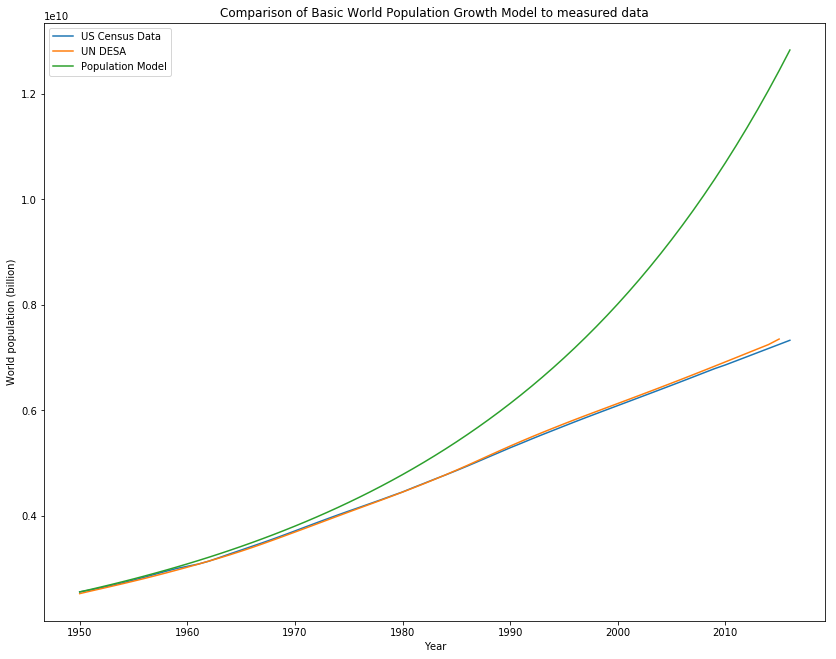

In [3]:
data_info = pd.Series({'filename':'data/World_population_estimates.html', 'table_choice_index':2, \
                       'fit_data_index':0, 'comp_data_index':2})
graph_info = pd.Series({'fit_data_label': 'US Census Data', 'comp_data_label': 'UN DESA'})

parsed_data = data_parser(data_info)
sim = proportional_population_model(parsed_data, lin_p_growth_update_constructor)
plot_model_results(sim, graph_info)